# Setup

In [1]:
#Libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import OPTICS
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

In [2]:
# Working directories
current_dir = os.getcwd()
print("Notebooks directory:", current_dir)
parent_dir = os.path.dirname(current_dir)
print("Local working directory:", parent_dir)
data_dir = parent_dir+"/data/"
print("Data directory:", data_dir)

Notebooks directory: /Users/omar/Documents/WQU-Capstone/notebooks
Local working directory: /Users/omar/Documents/WQU-Capstone
Data directory: /Users/omar/Documents/WQU-Capstone/data/


# Import Data

In [3]:
pkl_data = "etf_data_with_indicators.pkl"
etf_data = pd.read_pickle(pkl_data)

In [4]:
# Check the shape of the data
print(f"Number of ETFs: {len(etf_data)}")
print(f"Sample ETF data shape: {next(iter(etf_data.values())).shape}")

Number of ETFs: 75
Sample ETF data shape: (1761, 23)


In [5]:
# Create a combined dataframe with all ETFs' closing prices
etf_keys = list(etf_data.keys())
close_prices = pd.DataFrame()

In [18]:
# Extract closing prices for all ETFs
for ticker in etf_keys:
    if 'adjClose' in etf_data[ticker].columns:
        close_prices[ticker] = etf_data[ticker]['adjClose']

In [19]:
# Handle missing values
close_prices = close_prices.dropna(axis=0, how='any')
print(f"Price data shape after dropping NAs: {close_prices.shape}")

Price data shape after dropping NAs: (1760, 75)


In [20]:
# Calculate returns for PCA
returns = close_prices.pct_change().dropna()
print(f"Returns data shape: {returns.shape}")

Returns data shape: (1759, 75)


In [21]:
# Apply StandardScaler to returns
scaler = StandardScaler()
scaled_returns = pd.DataFrame(
    scaler.fit_transform(returns),
    index=returns.index,
    columns=returns.columns
)
# Transpose the scaled returns for PCA
scaled_returns = scaled_returns.T

# Applying PCA

In [22]:
# Setting components to 5
n_components = 5 
pca = PCA(n_components=n_components, random_state=42)
principal_components = pca.fit_transform(scaled_returns)

In [23]:
# Analyze explained variance
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

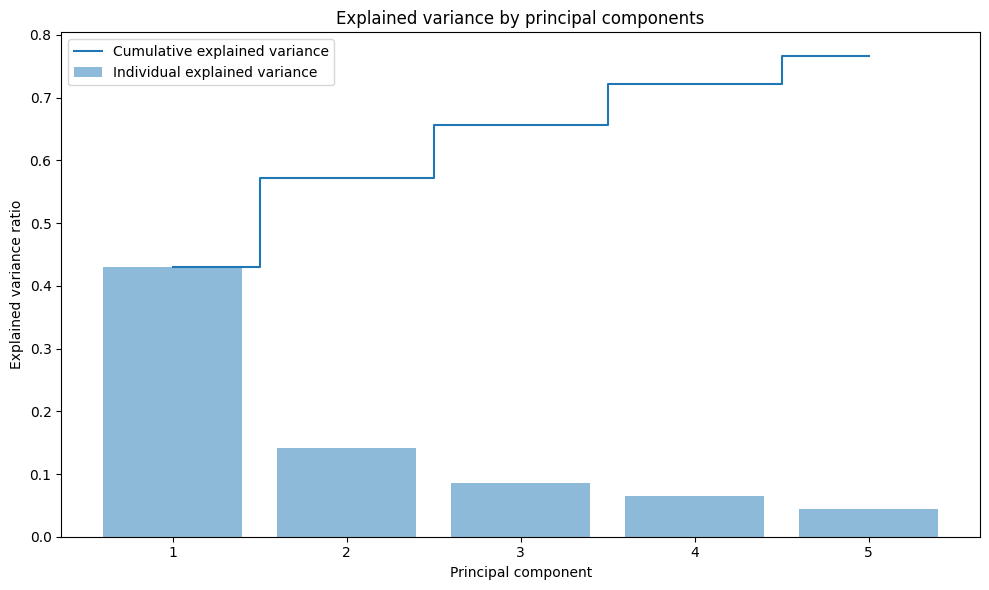

In [24]:
# Plot explained variance
plt.figure(figsize=(10, 6))
plt.bar(range(1, n_components + 1), explained_variance, alpha=0.5, align='center',
        label='Individual explained variance')
plt.step(range(1, n_components + 1), cumulative_variance, where='mid',
         label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component')
plt.legend(loc='best')
plt.title('Explained variance by principal components')
plt.tight_layout()
plt.show()

# Applying OPTICS

In [29]:
#clustering on the principal components
optics_clustering = OPTICS(min_samples=3, xi=0.05)
cluster_labels = optics_clustering.fit_predict(principal_components)

In [30]:
# Convert to pandas Series for easier handling
indices = scaled_returns.index  # Use the index of scaled_returns, which matches principal_components
clustered_series = pd.Series(cluster_labels, index=indices)
# Count ETFs per cluster
cluster_counts = pd.Series(clustered_series[clustered_series != -1].value_counts()).sort_index()
print(f"Clusters discovered: {len(cluster_counts)}")
print(f"Average cluster size: {np.mean(cluster_counts)}")
print(cluster_counts)

Clusters discovered: 8
Average cluster size: 5.75
0    3
1    9
2    3
3    7
4    7
5    7
6    6
7    4
Name: count, dtype: int64


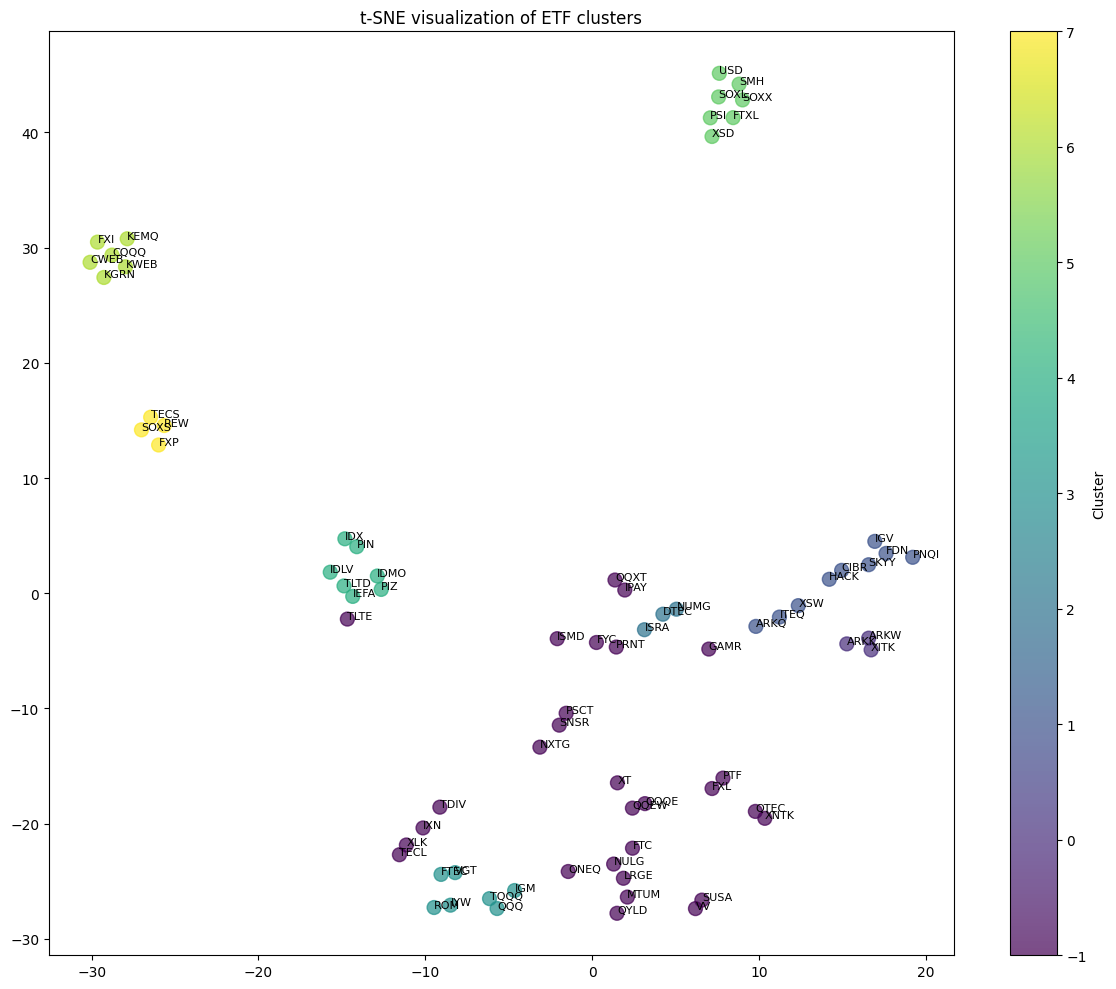

In [27]:
# Visualize clusters with t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=5)
tsne_results = tsne.fit_transform(principal_components)

# Plot t-SNE results
plt.figure(figsize=(12, 10))
scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=cluster_labels, cmap='viridis', alpha=0.7, s=100)
plt.colorbar(scatter, label='Cluster')
# Add ticker labels
for i, ticker in enumerate(close_prices.columns):
    plt.annotate(ticker, (tsne_results[i, 0], tsne_results[i, 1]), fontsize=8)

plt.title('t-SNE visualization of ETF clusters')
plt.tight_layout()
plt.savefig('PCA_OPTICS_clusters_tsne.png', dpi=150)
plt.show()


Cluster 0:
Number of ETFs: 3
Tickers: ARKK, ARKW, XITK


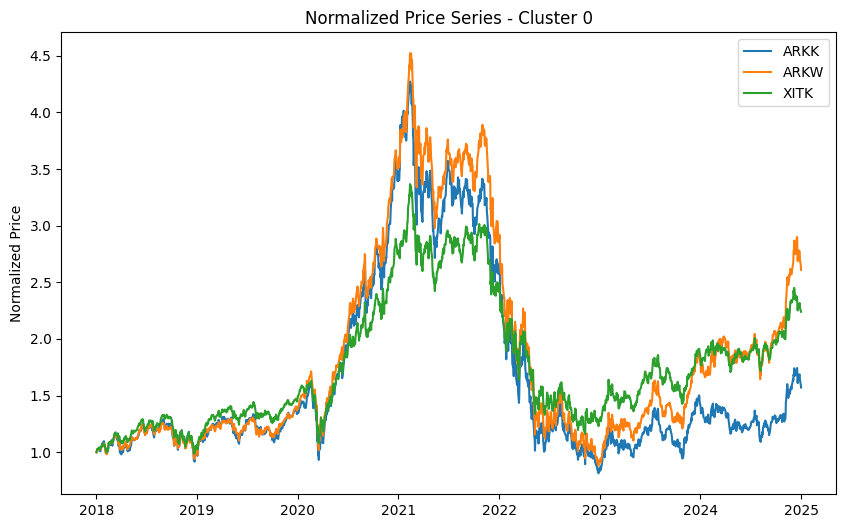


Cluster 1:
Number of ETFs: 9
Tickers: ARKQ, CIBR, FDN, HACK, IGV, ITEQ, PNQI, SKYY, XSW


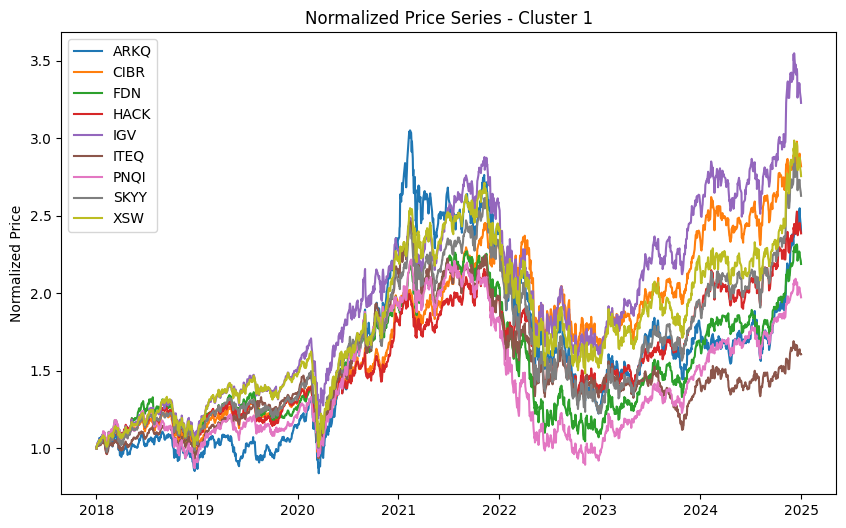


Cluster 2:
Number of ETFs: 3
Tickers: DTEC, ISRA, NUMG


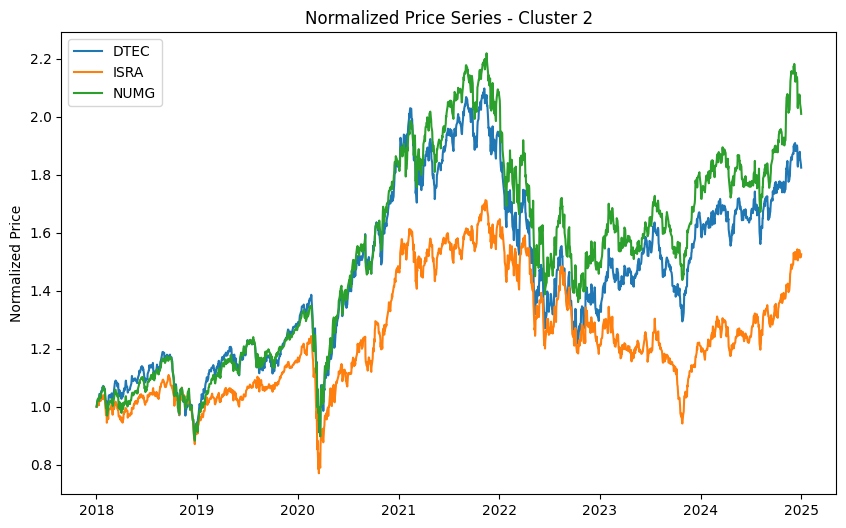


Cluster 3:
Number of ETFs: 7
Tickers: FTEC, IGM, IYW, QQQ, ROM, TQQQ, VGT


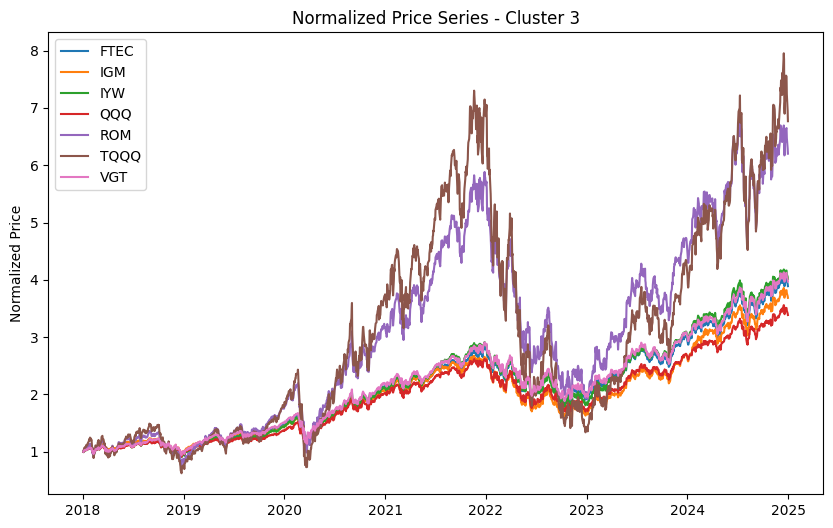


Cluster 4:
Number of ETFs: 7
Tickers: IDLV, IDMO, IDX, IEFA, PIN, PIZ, TLTD


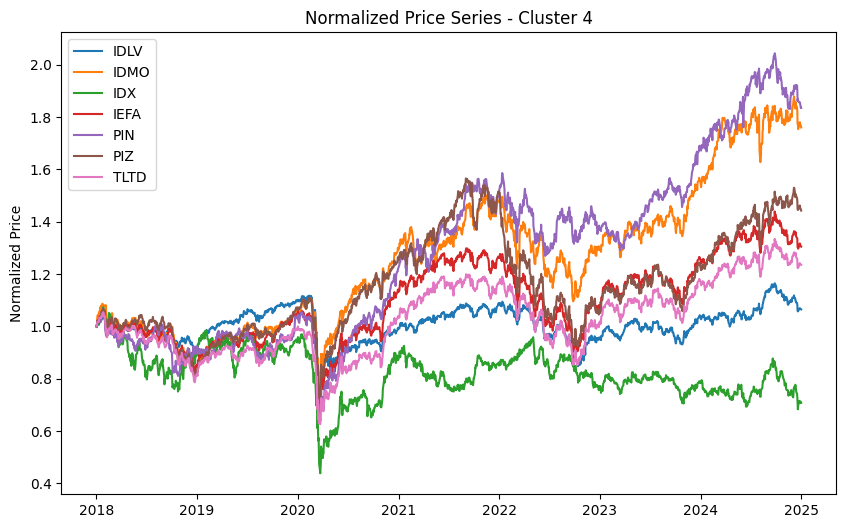


Cluster 5:
Number of ETFs: 7
Tickers: FTXL, PSI, SMH, SOXL, SOXX, USD, XSD


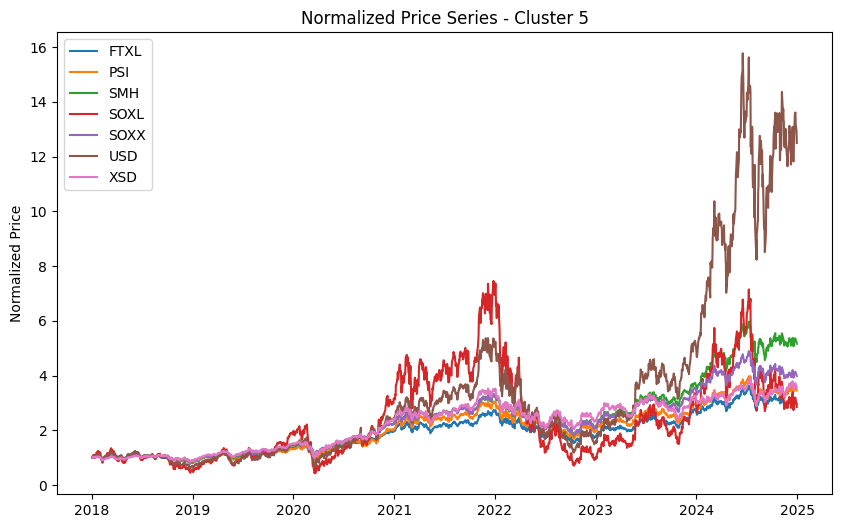


Cluster 6:
Number of ETFs: 6
Tickers: CQQQ, CWEB, FXI, KEMQ, KGRN, KWEB


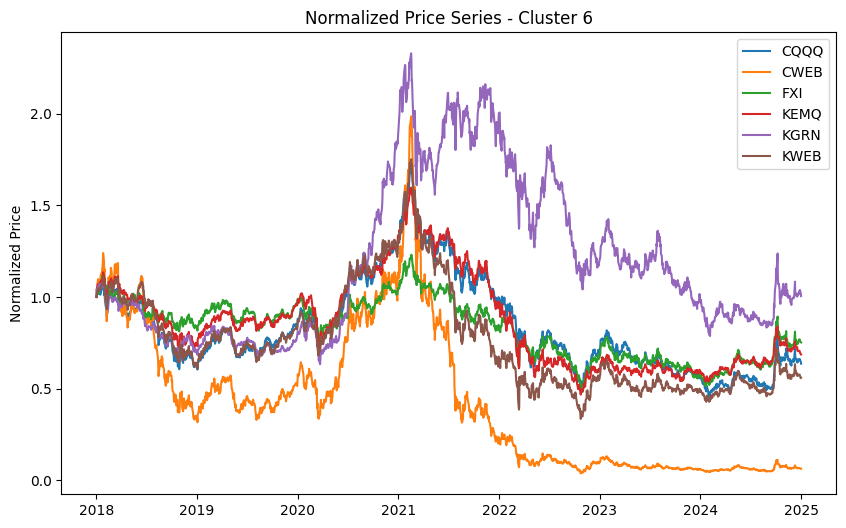


Cluster 7:
Number of ETFs: 4
Tickers: FXP, REW, SOXS, TECS


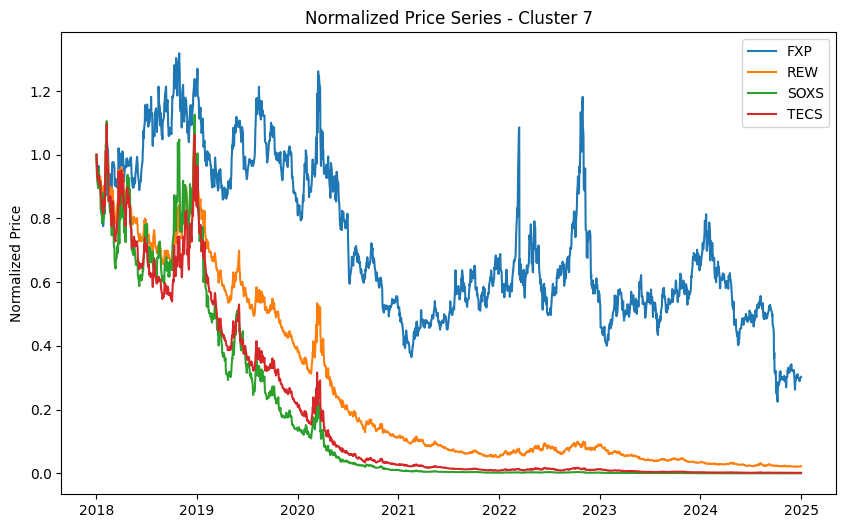

In [31]:
# Analyze clusters
for cluster_id in sorted(set(cluster_labels)):
    if cluster_id == -1:
        continue  # Skip noise points
        
    # Get tickers in this cluster
    mask = cluster_labels == cluster_id
    tickers_in_cluster = close_prices.columns[mask]
    print(f"\nCluster {cluster_id}:")
    print(f"Number of ETFs: {len(tickers_in_cluster)}")
    print(f"Tickers: {', '.join(tickers_in_cluster)}")
    
    # Plot the normalized price series for this cluster
    plt.figure(figsize=(10, 6))
    for ticker in tickers_in_cluster:
        # Normalize to start at 1
        normalized_prices = close_prices[ticker] / close_prices[ticker].iloc[0]
        plt.plot(normalized_prices, label=ticker)
    
    plt.title(f'Normalized Price Series - Cluster {cluster_id}')
    plt.ylabel('Normalized Price')
    plt.legend(loc='best')
    plt.savefig(f'cluster_{cluster_id}_prices.png', dpi=300, bbox_inches='tight')
    plt.show()